In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Function
import optuna
from modules import Trainer
from modules.competition_dataset import EEGDataset
from modules.utils import evaluate_model
import random
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/ai_data/eeg_detection/data/mtcaic3'
# model_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/models/ssvep.pth'
# optuna_db_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/optuna/optuna_studies.db'
data_path = './data/mtcaic3'
model_path = './checkpoints/mi/models/the_honored_one.pth'
optuna_db_path = './checkpoints/mi/optuna/the_honored_one.db'
eeg_channels = [
    "C3", # 2296.15
    "PZ", # 1744.43
    "C4", # 1556.46
    "OZ", # 444.98
    "PO7", # 381.63
    "PO8", # 275.78
    "CZ", # 200.43
    "FZ", # 111.51
]

In [4]:
# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this function before creating datasets and models
set_random_seeds(42)

In [5]:
window_length = 128 * 2 # ensure divisble by 64 the kernel size to prevent data loss
stride = window_length // 3
batch_size = 64

dataset_train = EEGDataset(
    data_path,
    window_length=window_length,
    stride=stride,
    domain="time",
    data_fraction=0.08,
    hardcoded_mean=True,
    task="mi",
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    split='validation',
    read_labels=True,
    hardcoded_mean=True,
    data_fraction=1,
    task="mi",
    eeg_channels=eeg_channels,
)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size)

task: mi, split: train, domain: time, data_fraction: 0.08
Using 8.0% of data: 192/192 samples
skipped: 0/192
task: mi, split: validation, domain: time, data_fraction: 1
skipped: 0/50


In [6]:
dataset_train[0][0].shape

torch.Size([8, 40, 256])

In [44]:
# ---------------- Gradient Reversal Layer ---------------- #
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None


class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)


# ---------------- LSTM Head ---------------- #
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # x: B x seq_len x feat_dim
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        last_time_step = out[:, -1, :]
        return self.fc(last_time_step), out


# ---------------- EEG Feature Extractor (3D) ---------------- #
class EEGFeatureExtractor3D(nn.Module):
    def __init__(self, n_electrodes, kernLength, F1, D, F2, dropout):
        super().__init__()
        # Input: B×C×F×T. After unsqueeze: B×1×C×F×T.
        # 1) Temporal+Spectral conv per electrode
        self.temporal_spec = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=F1, kernel_size=(1, 5, kernLength), padding=(0, 2, kernLength // 2), bias=False),
            nn.BatchNorm3d(F1),
            nn.ELU(),
        )
        # 2) Depthwise spatial conv across electrodes
        self.spatial = nn.Sequential(
            nn.Conv3d(in_channels=F1, out_channels=F1 * D, kernel_size=(n_electrodes, 1, 1), groups=F1, bias=False),
            nn.BatchNorm3d(F1 * D),
            nn.ELU(),
            nn.MaxPool3d((1, 1, 2)),  # half the time‐axis
            nn.Dropout(dropout),
        )
        # 3) Separable freq‐time conv
        self.separable = nn.Sequential(
            nn.Conv3d(in_channels=F1 * D, out_channels=F1 * D, kernel_size=(1, 7, 16), padding=(0, 3, 8), groups=F1 * D, bias=False),
            nn.Conv3d(in_channels=F1 * D, out_channels=F2, kernel_size=1, bias=False),
            nn.BatchNorm3d(F2),
            nn.ELU(),
            nn.MaxPool3d((1, 1, 2)),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: B×C×F×T
        B, C, F, T = x.shape
        x = x.unsqueeze(1)  # → B×1×C×F×T
        x = self.temporal_spec(x)  # → B×F1×C×F×T_sub
        x = self.spatial(x)  # → B×(F1·D)×1×F×T_sub
        x = self.separable(x)  # → B×F2×1×F'×T_sub2

        # squeeze out the now‐unit “electrode” dim
        x = x.squeeze(2)  # B×F2×F'×T_sub2
        B, F2, Fp, Tp = x.shape

        # merge frequency into the feature axis:
        x = x.view(B, F2 * Fp, Tp)  # B×feat_dim×T_sub2
        # finally, transpose for LSTM: B×T_sub2×feat_dim
        return x.permute(0, 2, 1)


# ---------------- DANN SSVEP Classifier ---------------- #
class DANN_SSVEPClassifier(nn.Module):
    def __init__(
        self,
        n_electrodes=16,
        out_dim=4,
        dropout=0.25,
        kernLength=256,
        F1=96,
        D=1,
        F2=96,
        hidden_dim=256,
        layer_dim=1,
        grl_alpha=0.0,
        domain_lstm_div=3,
        domain_classes=30,
    ):
        super().__init__()
        self.grl_alpha = grl_alpha
        self.feature_extractor = EEGFeatureExtractor3D(n_electrodes, kernLength, F1, D, F2, dropout)
        feat_dim = F2 * (40 // 1)  # update with actual F' if needed

        self.label_lstm = LSTMModel(feat_dim, hidden_dim, layer_dim, out_dim)

        self.grl_layer = GradientReversal(alpha=grl_alpha)
        self.domain_classifier = LSTMModel(hidden_dim, max(1, hidden_dim // domain_lstm_div), max(1, layer_dim // domain_lstm_div), domain_classes)

    def forward(self, x):
        # x: B×C×F×T  (from your CWT)
        seq = self.feature_extractor(x)  # B×T_sub×feat_dim
        class_out, last_time_step = self.label_lstm(seq)  # B×out_dim, Bxhidden_dim

        domain_out, _ = self.domain_classifier(self.grl_layer(last_time_step))
        return class_out, domain_out
        
    def set_grl_alpha(self, new_grl):
        self.grl_layer = GradientReversal(alpha=new_grl)
        

dummy_x = torch.randn(5, 8, 40, 256).to(device)
model = DANN_SSVEPClassifier(
    dropout=0.26211635308091535,
    n_electrodes=8,
    out_dim=2,
    domain_classes=30,
    kernLength=8,
    F1=8,
    D=2,
    F2=16,
    hidden_dim=256,
    layer_dim=1,
    grl_alpha=0,
    domain_lstm_div=2,
).to(device)

print("worked dude")
model(dummy_x)

worked dude


(tensor([[-0.1616,  0.0518],
         [ 0.0624,  0.1255],
         [-0.0758, -0.1487],
         [-0.0749, -0.0788],
         [-0.0541,  0.1200]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.1726,  0.0342, -0.0561,  0.0033,  0.1109,  0.0203, -0.0813,  0.0566,
           0.0182,  0.0536,  0.0460, -0.0212,  0.0750,  0.0027,  0.0300,  0.0295,
          -0.0412,  0.1246,  0.0021,  0.0262, -0.1077, -0.0506,  0.0324,  0.0179,
           0.0122, -0.0511,  0.0549, -0.0074, -0.0524, -0.0258],
         [ 0.1101,  0.0470, -0.0915, -0.0049,  0.0540,  0.0610, -0.0247,  0.0428,
           0.0473,  0.0681,  0.0470, -0.0293,  0.0290, -0.0276,  0.1076,  0.0224,
          -0.0280,  0.0397, -0.0554,  0.0542, -0.1805, -0.0671,  0.0354,  0.1012,
          -0.0071, -0.0229,  0.0451, -0.0291, -0.0552, -0.0217],
         [ 0.1080,  0.1230, -0.0883, -0.0228,  0.0209,  0.0935, -0.0385,  0.0272,
           0.0175,  0.0470,  0.0245, -0.0633,  0.0706, -0.0611,  0.0437, -0.0213,
          -0.0291,  0.0201, -0.0485,  0.0

In [45]:
avg_losses_label = []
avg_losses_domain = []
val_label_accuracies = []
val_domain_accuracies = []
train_label_accuracies = []
train_domain_accuracies = []

In [ ]:
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
except Exception:
    print("skipping model loading...")


opt = torch.optim.Adam(model.parameters(), lr=0.0003746351873334935)
criterion = nn.CrossEntropyLoss()
epochs = 20
domain_loss_weight = 0.2

for epoch in range(epochs):
    avg_loss_label = 0
    avg_loss_domain = 0
    correct_label = 0
    correct_domain = 0
    total = 0
    
    new_grl_alpha = 2.0 / (1.0 + np.exp(-10 * (epoch/epochs))) - 1.0
    model.set_grl_alpha(new_grl_alpha)
    model.train()

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device).to(torch.int64) # shape: [Bx2], 0: label, 1: domain
        y_labels = y[:, 0]
        y_subj = y[:, 1]

        y_pred_labels, y_pred_domain = model(x)

        loss_label = criterion(y_pred_labels, y_labels)
        loss_domain = criterion(y_pred_domain, y_subj)
        loss = loss_label + domain_loss_weight * loss_domain
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss_label += loss.item()
        avg_loss_domain += loss_domain.item()

        # Accuracy calculation
        _, pred_labels = torch.max(y_pred_labels, 1)
        _, pred_domains = torch.max(y_pred_domain, 1)
        correct_label += (pred_labels == y_labels).sum().item()
        correct_domain += (pred_domains == y_subj).sum().item()
        total += y_labels.size(0)

    avg_loss_label /= len(train_loader)
    avg_loss_domain /= len(train_loader)
    avg_losses_label.append(avg_loss_label)
    avg_losses_domain.append(avg_loss_domain)
    train_label_acc = 100.0 * correct_label / total
    train_domain_acc = 100.0 * correct_domain / total
    train_label_accuracies.append(train_label_acc)
    train_domain_accuracies.append(train_domain_acc)

    if (epoch + 1) % 5 == 0 or True:
        label_evaluation, domain_evaluation = evaluate_model(model, val_loader, device)
        val_label_accuracies.append(label_evaluation)
        val_domain_accuracies.append(domain_evaluation)
        model.cpu()
        torch.save(model.state_dict(), model_path)
        model.to(device)
        print(
            f"Epoch {epoch+1:2d}/{epochs} | "
            f"Label Loss: {avg_loss_label:.4f} | "
            f"Domain Loss: {avg_loss_domain:.4f} | "
            f"Train Label Acc: {train_label_acc:.2f}% | "
            f"Train Domain Acc: {train_domain_acc:.2f}% | "
            f"Val Label Acc: {label_evaluation*100:.2f}% | "
            f"Val Domain Acc: {domain_evaluation*100:.2f}% | "
            f"LR: {opt.param_groups[0]['lr']:.6f} | "
            f"GRL: {new_grl_alpha:.6f}"
        )

skipping model loading...
Epoch  1/20 | Label Loss: 1.2176 | Domain Loss: 3.1703 | Train Label Acc: 68.27% | Train Domain Acc: 18.58% | Val Label Acc: 54.37% | Val Domain Acc: 0.00% | LR: 0.000375 | GRL: 0.000000


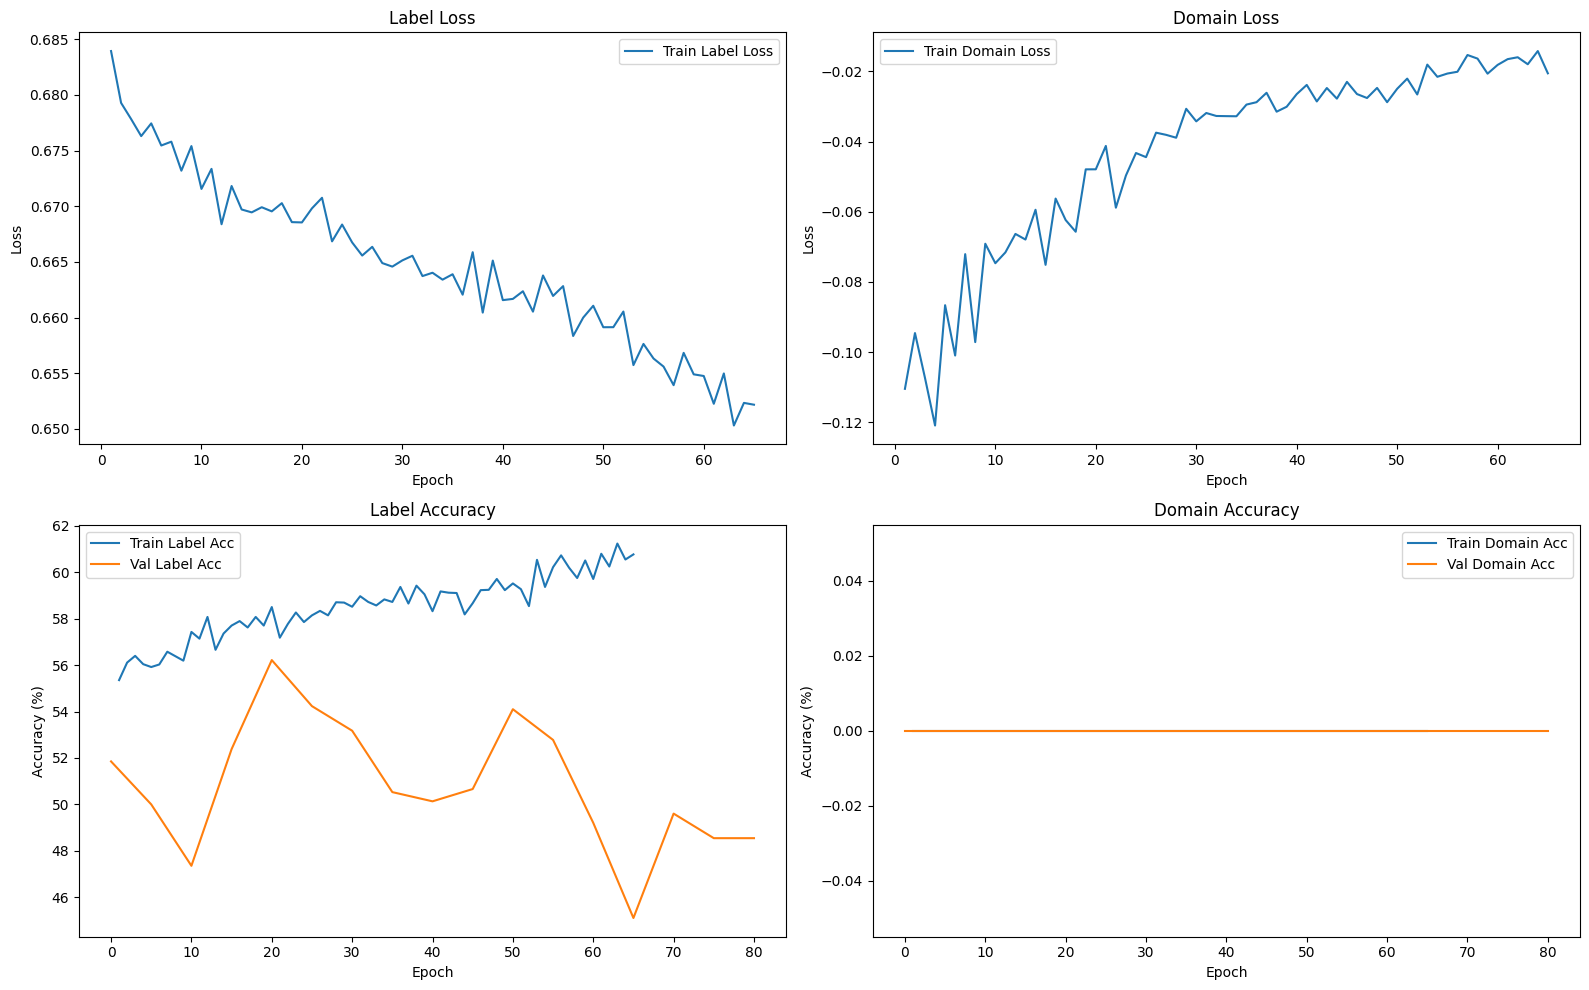

In [19]:
epochs = range(1, len(avg_losses_label) + 1)
val_epochs = range(0, len(val_label_accuracies) * 5, 5)  # if you log every 5 epochs

plt.figure(figsize=(16, 10))

# 1. Label Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, avg_losses_label, label='Train Label Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Label Loss')
plt.legend()

# 2. Domain Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, avg_losses_domain, label='Train Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Loss')
plt.legend()

# 3. Label Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_label_accuracies, label='Train Label Acc')
plt.plot(val_epochs, [v*100 for v in val_label_accuracies], label='Val Label Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Label Accuracy')
plt.legend()

# 4. Domain Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, train_domain_accuracies, label='Train Domain Acc')
plt.plot(val_epochs, [v*100 for v in val_domain_accuracies], label='Val Domain Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Domain Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CustomTrainer(Trainer):
    # Called by _objective during an Optuna trial
    def prepare_trial_run(self):
        assert isinstance(self.trial, optuna.Trial), "Trial not set!"

        # 1) Hyperparameter search space
        # Data params
        window_length = self.trial.suggest_categorical("window_length", [128, 256, 640])
        batch_size    = self.trial.suggest_categorical("batch_size", [32, 64])

        # Model extractor params (based on EEG3D+MDD)
        kernLength = self.trial.suggest_categorical("kernLength", [8, 16, 32, 64, 128])
        F1         = self.trial.suggest_categorical("F1", [8, 16, 32, 64])
        D          = self.trial.suggest_categorical("D", [1, 2, 4])
        F2         = self.trial.suggest_categorical("F2", [16, 32, 64, 128])
        dropout    = self.trial.suggest_float("dropout", 0.1, 0.5)
        # MDD head params
        hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
        layer_dim  = self.trial.suggest_int("layer_dim", 1, 3)
        # MDD alignment weight
        lambda_mdd = self.trial.suggest_float("lambda_mdd", 0.1, 1.0)

        # Optimizer
        lr = self.trial.suggest_float("lr", 1e-5, 1e-3, log=True)

        # 2) Prepare data
        super()._prepare_data(is_trial=True,
                              batch_size=batch_size,
                              window_length=window_length)

        # 3) Build MDD model
        extractor_kwargs = dict(
            n_electrodes=self.data.num_channels,
            kernLength=kernLength,
            F1=F1,
            D=D,
            F2=F2,
            dropout=dropout,
        )
        lstm_kwargs = dict(
            input_dim=F2 * (self.data.freq_bins // D),  # adjust if freq_bins variable
            hidden_dim=hidden_dim,
            layer_dim=layer_dim,
            output_dim=self.data.num_classes,
        )
        self.model = MDD_SSVEPClassifier(
            extractor_kwargs=extractor_kwargs,
            lstm_kwargs=lstm_kwargs
        ).to(self.device)
        self.lambda_mdd = lambda_mdd

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # Called by train() for final run
    def prepare_final_run(self):
        study      = self._get_study()
        best       = study.best_params
        # Data
        super()._prepare_data(is_trial=False)
        # Build final model
        extractor_kwargs = dict(
            n_electrodes=self.data.num_channels,
            kernLength=best["kernLength"],
            F1=best["F1"],
            D=best["D"],
            F2=best["F2"],
            dropout=best["dropout"],
        )
        lstm_kwargs = dict(
            input_dim=best["F2"] * (self.data.freq_bins // best["D"]),
            hidden_dim=best["hidden_dim"],
            layer_dim=best["layer_dim"],
            output_dim=self.data.num_classes,
        )
        self.model = MDD_SSVEPClassifier(
            extractor_kwargs=extractor_kwargs,
            lstm_kwargs=lstm_kwargs
        ).to(self.device)
        # load weights?
        try:
            self.model.load_state_dict(torch.load(self.model_path))
            print(f"Loaded weights from {self.model_path}")
        except:
            print("No checkpoint found, training from scratch.")

        lr = best["lr"]
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max', factor=0.5, patience=20,
            threshold=1e-4, threshold_mode='rel',
            cooldown=0, min_lr=1e-6
        )

trainer = CustomTrainer(
        data_path=data_path,
        optuna_db_path=optuna_db_path,
        model_path=model_path,
        train_epochs=500, # Final training epochs
        tune_epochs=50,   # Epochs per trial
        optuna_n_trials=50,
        task="mi",
        eeg_channels=eeg_channels,
        data_fraction=0.4
    )

In [ ]:
delete_existing = False
trainer.optimize(delete_existing)

In [ ]:
trainer.train()

In [ ]:
trainer._prepare_training(False)
trainer.model.eval()
f"test accuracy: {evaluate_model(trainer.model, trainer.eval_loader, device)}"